# Data import

In [1]:
import os
import pathlib
from pprint import pprint
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate, Input, Lambda, Rescaling
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.tuners import Hyperband
from keras_tuner import Objective

from scipy.ndimage import gaussian_filter1d


# Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q /content/gdrive/MyDrive/dataset.zip

Mounted at /content/gdrive/


In [2]:
img_width = 150
img_height = 150
batch_size = 32
learningrate = 0.0001

In [3]:
def load_images(directory, target_size=(img_width, img_height), normalize=True):
    images, labels = [], []
    valid_extensions = ['.jpg', '.jpeg', '.png']
    for label_class, klass in enumerate(['chihuahua', 'muffin']):
        class_dir = os.path.join(directory, klass)
        for file in os.listdir(class_dir):
            if os.path.splitext(file)[1].lower() in valid_extensions:
                img_path = os.path.join(class_dir, file)
                try:
                    img = load_img(img_path, target_size=target_size)
                    img = img_to_array(img)
                    if normalize:
                        img /= 255.0
                    images.append(img)
                    labels.append(label_class)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

train_images, train_labels = load_images('dataset/train')
test_images, test_labels = load_images('dataset/test')

# Util functions

In [4]:
def get_model_data(model, filename="model", augmentation=True, num_epochs=20, lr=learningrate):
    augmented_model = Sequential([model])
    if augmentation:
        data_augmentation = Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=(-0.15, 0.15)),
            layers.RandomContrast(0.2),
            layers.RandomZoom(-.1, 0.1),
        ], "Data_Augmentation")
        augmented_model = Sequential([data_augmentation, model])

    opt = keras.optimizers.Adam(learning_rate=lr)
    augmented_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

    early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    train_history = augmented_model.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs, validation_data=(x_val, y_val), verbose=2, callbacks=[early_stop])

    train_history_df = pd.DataFrame(train_history.history)
    train_history_df['epoch'] = train_history_df.index + 1
    plot_train_history_smooth(train_history_df, filename=filename)

    test_predicted_labels = np.around(model.predict(test_images))
    plot_confusion_matrix(confusion_matrix(test_labels, test_predicted_labels), filename=filename)
    report = classification_report(test_labels, test_predicted_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    test_score = augmented_model.evaluate(test_images, test_labels, batch_size = batch_size, verbose = 2)
    kf_stats  = run_kfold(augmented_model)
    process_kfold_stats(kf_stats, filename)
    return augmented_model, train_history_df, test_score, kf_stats, report_df

In [5]:
def plot_train_history_smooth(history_df, filename="model_train_val_acc", smoothing_window=3):
    sns.set(style="ticks")

    history_df['smoothed_loss'] = history_df['loss']
    history_df['smoothed_val_loss'] = history_df['val_loss']
    history_df['smoothed_accuracy'] = history_df['accuracy']
    history_df['smoothed_val_accuracy'] = history_df['val_accuracy']

    melted_df_loss = pd.melt(history_df, ['epoch'], value_vars=['smoothed_loss', 'smoothed_val_loss'], var_name='variable', value_name='value')
    melted_df_accuracy = pd.melt(history_df, ['epoch'], value_vars=['smoothed_accuracy', 'smoothed_val_accuracy'], var_name='variable', value_name='value')

    plt.figure(figsize=(16, 8))

    # Loss plot
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
    loss_plot = sns.lineplot(x='epoch', y='value', hue='variable', data=melted_df_loss, marker='o', palette=['black', 'red'])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(history_df['epoch']) + 1))  # Setting x-axis ticks to be integer values of epochs
    handles, labels = loss_plot.get_legend_handles_labels()
    loss_plot.legend(handles=handles, labels=['Training Loss', 'Validation Loss'], title='Type')
    plt.gca().set_facecolor('#FBFBFB')

    # Accuracy plot
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
    accuracy_plot = sns.lineplot(x='epoch', y='value', hue='variable', data=melted_df_accuracy, marker='o', palette=['black', 'red'])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(history_df['epoch']) + 1))
    handles, labels = accuracy_plot.get_legend_handles_labels()
    accuracy_plot.legend(handles=handles, labels=['Training Accuracy', 'Validation Accuracy'], title='Type')

    plt.tight_layout()
    plt.gca().set_facecolor('#FBFBFB')
    plt.savefig(filename + "_train_graphs_smooth.jpg", dpi=300)

In [6]:
def plot_confusion_matrix(test_conf_matrix, filename="cm"):
  sns.set(style="whitegrid")
  plt.figure(figsize=(8, 6))
  sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=["Chihuahua", "Muffin"], yticklabels=["Chihuahua", "Muffin"])
  plt.xlabel('Predicted Labels', fontsize=16)
  plt.ylabel('True Labels', fontsize=16)
  plt.title('Confusion Matrix')
  plt.savefig(filename + "_cm.jpg", dpi=300)

In [7]:
def run_kfold(augmented_model, num_folds = 5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_histories = []
    fold_scores = []
    early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    fold_no = 1
    for train_index, test_index in kf.split(train_images):
        x_train, x_val = train_images[train_index], train_images[test_index]
        y_train, y_val = train_labels[train_index], train_labels[test_index]
        opt = keras.optimizers.Adam(learning_rate=learningrate)
        augmented_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        print(f'Training on fold {fold_no}...')
        history = augmented_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), verbose=2, callbacks=[early_stop])
        scores = augmented_model.evaluate(test_images, test_labels)
        fold_histories.append(history)
        fold_scores.append(scores)

        fold_no += 1


    for idx, h in enumerate(fold_histories):
        fold_histories[idx] = pd.DataFrame(h.history)

    return (fold_histories, fold_scores)

In [8]:
def process_kfold_stats(kf_stats, modelname="model"):
    fold_histories = kf_stats[0]
    history = pd.concat(fold_histories, ignore_index=True)

    val_acc_avg = history['val_accuracy'].mean()
    val_acc_std = history['val_accuracy'].std()
    train_acc_avg = history['accuracy'].mean()
    train_acc_std = history['accuracy'].std()

    print("Training Accuracy Average:", train_acc_avg)
    print("Training Accuracy Std Dev:", train_acc_std)
    print("Validation Accuracy Average:", val_acc_avg)
    print("Validation Accuracy Std Dev:", val_acc_std)

    fold_acc = [df['val_accuracy'] for df in fold_histories]
    sns.set(style="whitegrid", context="notebook", palette="bright")
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, fold in enumerate(fold_acc, start=1):
        smooth_fold = gaussian_filter1d(fold, sigma=1)
        ax.plot(smooth_fold, marker='o', label=f'Fold {i}')

    ax.set_xlabel('Epoch')
    ax.set_xticks(range(len(smooth_fold)))
    ax.set_ylabel('Accuracy')
    ax.set_title('Fold Accuracy Across Multiple Folds')
    ax.legend(title='Fold Number', loc='upper left', bbox_to_anchor=(1.05, 1))
    sns.despine()
    plt.gca().set_facecolor('#FBFBFB')
    plt.savefig(modelname + "_kfold.png", bbox_inches='tight')

# Create MLP

In [9]:
def create_mlp():
    model = Sequential([
        Flatten(input_shape=(img_width, img_height, 3)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ], name="MLP")
    return model

Epoch 1/20
119/119 - 9s - loss: 0.9176 - accuracy: 0.5135 - val_loss: 0.6863 - val_accuracy: 0.5238 - 9s/epoch - 73ms/step
Epoch 2/20
119/119 - 2s - loss: 0.6843 - accuracy: 0.5436 - val_loss: 0.6638 - val_accuracy: 0.6579 - 2s/epoch - 16ms/step
Epoch 3/20
119/119 - 2s - loss: 0.6493 - accuracy: 0.6223 - val_loss: 0.6434 - val_accuracy: 0.6262 - 2s/epoch - 16ms/step
Epoch 4/20
119/119 - 2s - loss: 0.6300 - accuracy: 0.6572 - val_loss: 0.6270 - val_accuracy: 0.6346 - 2s/epoch - 16ms/step
Epoch 5/20
119/119 - 2s - loss: 0.6247 - accuracy: 0.6569 - val_loss: 0.6034 - val_accuracy: 0.7022 - 2s/epoch - 16ms/step
Epoch 6/20
119/119 - 2s - loss: 0.6013 - accuracy: 0.6883 - val_loss: 0.7285 - val_accuracy: 0.5766 - 2s/epoch - 16ms/step
Epoch 7/20
119/119 - 2s - loss: 0.6028 - accuracy: 0.6931 - val_loss: 0.6041 - val_accuracy: 0.7254 - 2s/epoch - 16ms/step
Epoch 8/20
119/119 - 2s - loss: 0.5814 - accuracy: 0.7026 - val_loss: 0.5281 - val_accuracy: 0.7413 - 2s/epoch - 16ms/step
Epoch 9/20
119/1

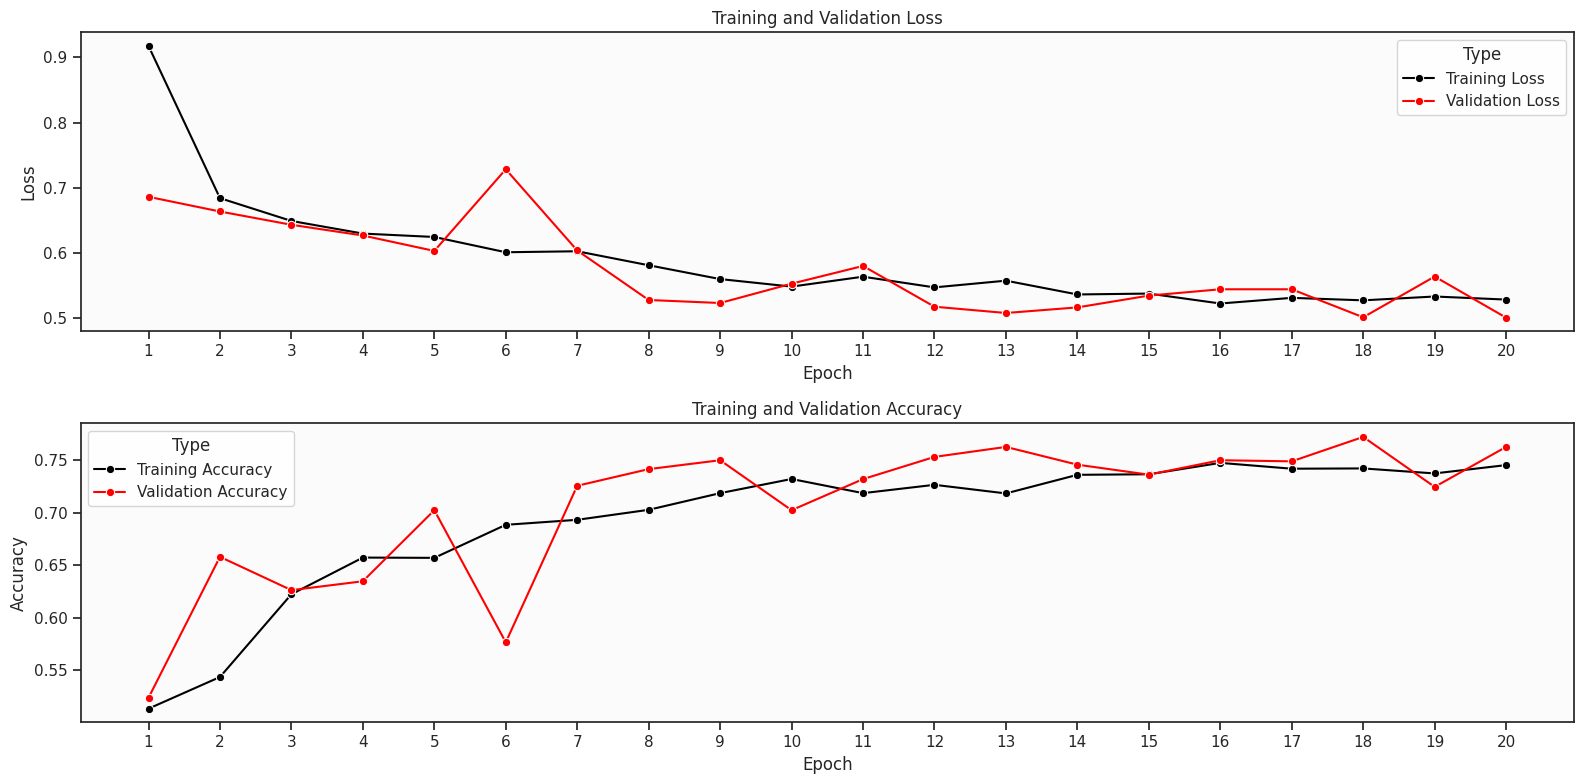

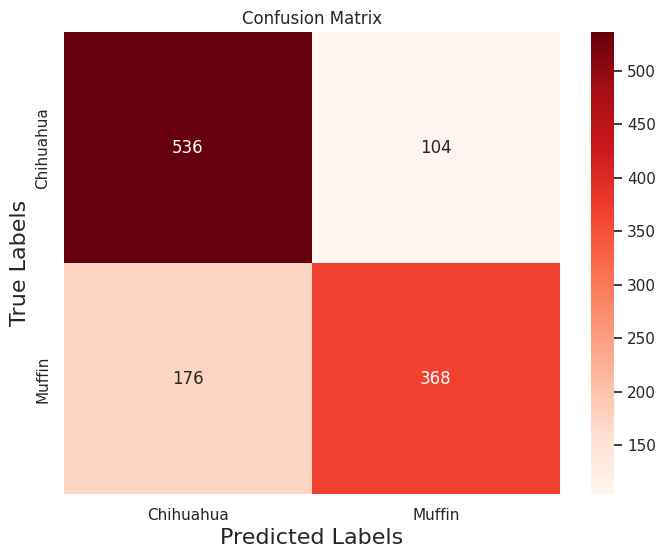

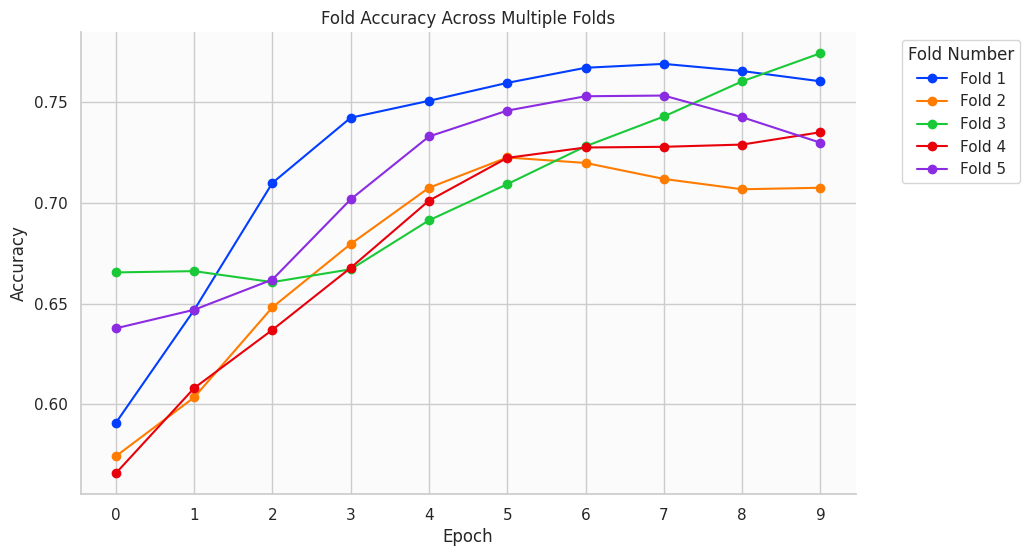

In [10]:
mlp, train_data, test_data, kf_stats, report = get_model_data(create_mlp(), filename="MLP", num_epochs=20)

In [11]:
print("Test data")
print("*********************")
print("Accuracy: ", end="")
print(test_data[1])
print("Loss: ", end="")
print(test_data[0])

Test data
*********************
Accuracy: 0.7635135054588318
Loss: 0.49318554997444153


In [12]:
report

,precision,recall,f1-score,support
0,0.752809,0.837500,0.792899,640.000000
1,0.779661,0.676471,0.724409,544.000000
accuracy,0.763514,0.763514,0.763514,0.763514
macro avg,0.766235,0.756985,0.758654,1184.000000
weighted avg,0.765146,0.763514,0.761431,1184.000000


# Create CNN1 (Basic)

In [9]:
def create_cnn1():
  model = Sequential([
      Conv2D(128, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
      MaxPooling2D(2, 2),
      Dropout(0.2),
      Conv2D(64, (3, 3), activation='relu'),
      MaxPooling2D(2, 2),
      Dropout(0.2),
      Conv2D(32, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D(2, 2),
      Dropout(0.2),
      Flatten(input_shape=(img_width, img_height, 3)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

Epoch 1/20
119/119 - 15s - loss: 0.6346 - accuracy: 0.6738 - val_loss: 0.6421 - val_accuracy: 0.7983 - 15s/epoch - 129ms/step
Epoch 2/20
119/119 - 5s - loss: 0.5039 - accuracy: 0.7665 - val_loss: 0.6035 - val_accuracy: 0.7086 - 5s/epoch - 46ms/step
Epoch 3/20
119/119 - 5s - loss: 0.4477 - accuracy: 0.8001 - val_loss: 0.6148 - val_accuracy: 0.6600 - 5s/epoch - 46ms/step
Epoch 4/20
119/119 - 5s - loss: 0.4029 - accuracy: 0.8148 - val_loss: 0.6895 - val_accuracy: 0.6262 - 5s/epoch - 46ms/step
Epoch 5/20
119/119 - 6s - loss: 0.3711 - accuracy: 0.8407 - val_loss: 0.3835 - val_accuracy: 0.8247 - 6s/epoch - 46ms/step
Epoch 6/20
119/119 - 5s - loss: 0.3440 - accuracy: 0.8553 - val_loss: 0.3685 - val_accuracy: 0.8405 - 5s/epoch - 46ms/step
Epoch 7/20
119/119 - 5s - loss: 0.3500 - accuracy: 0.8534 - val_loss: 0.5355 - val_accuracy: 0.7814 - 5s/epoch - 46ms/step
Epoch 8/20
119/119 - 5s - loss: 0.3244 - accuracy: 0.8653 - val_loss: 0.6190 - val_accuracy: 0.7518 - 5s/epoch - 46ms/step
Epoch 9/20
11

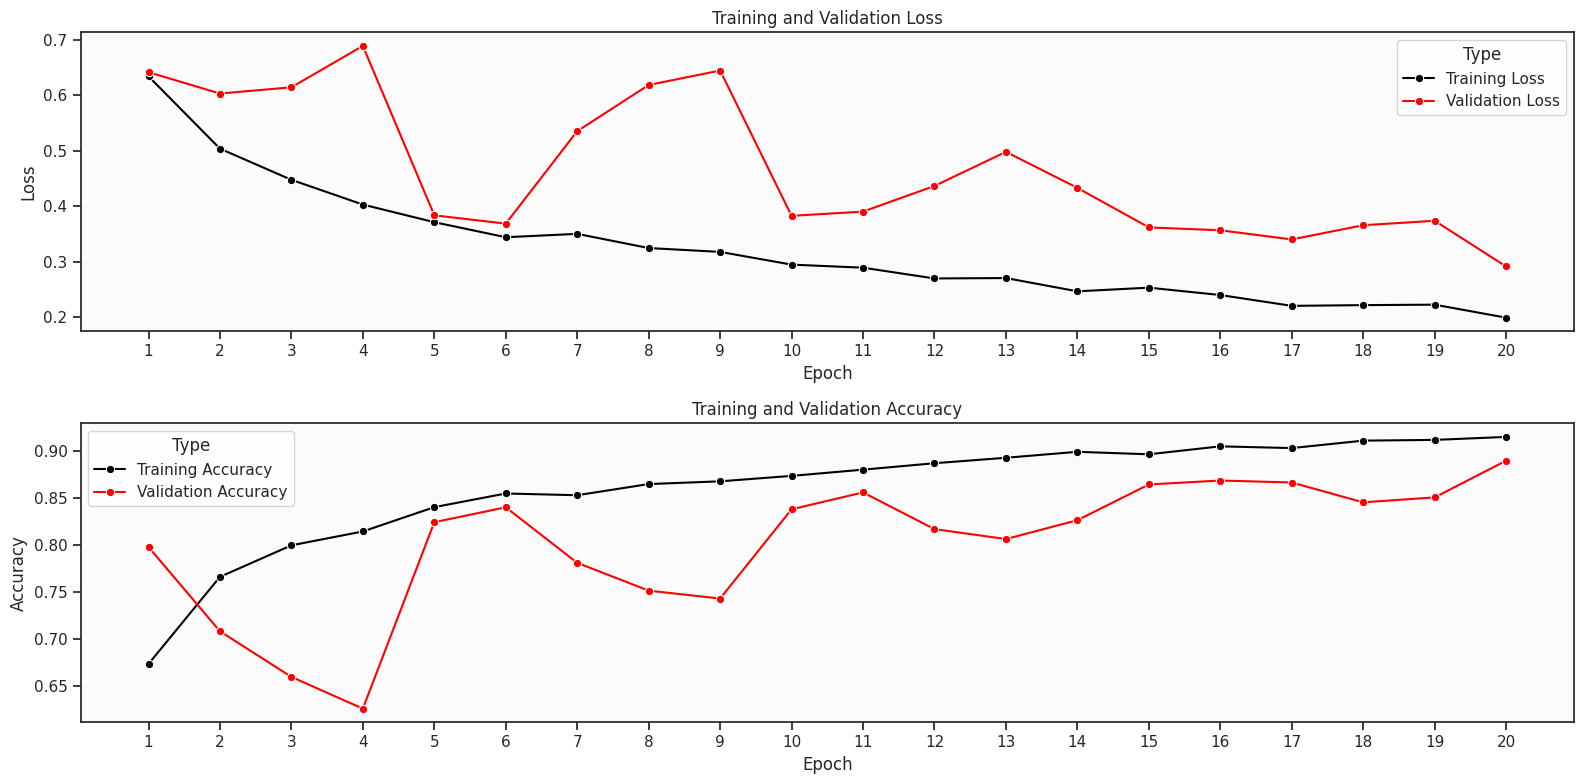

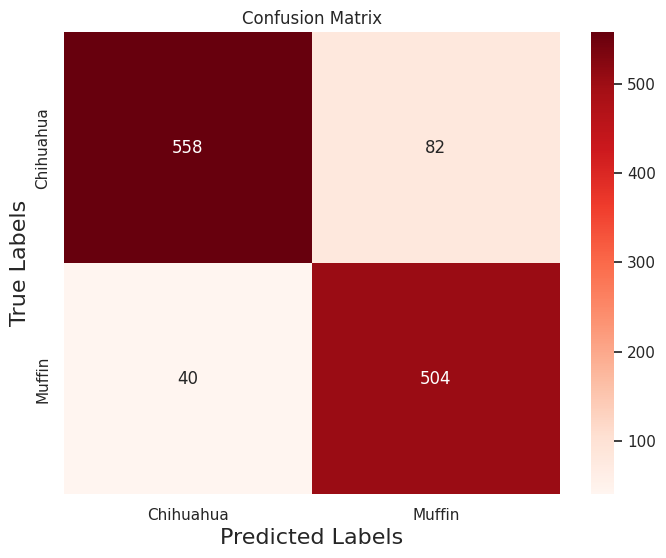

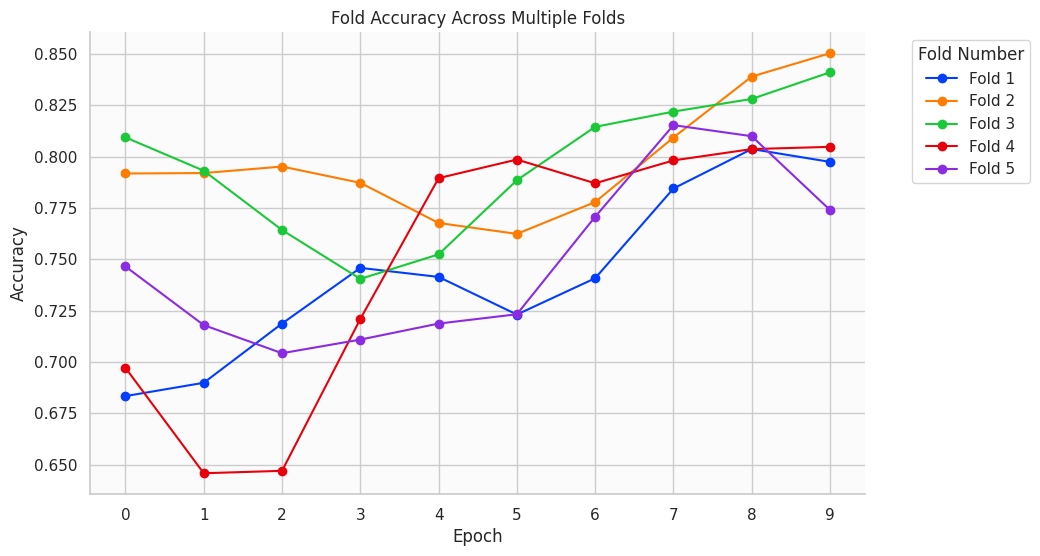

In [12]:
cnn1, train_data, test_data, kf_stats, report = get_model_data(create_cnn1(), filename="CNN1", num_epochs=20)

In [13]:
print("Test data")
print("*********************")
print("Accuracy: ", end="")
print(test_data[1])
print("Loss: ", end="")
print(test_data[0])

Test data
*********************
Accuracy: 0.8969594836235046
Loss: 0.291730135679245


In [14]:
report

,precision,recall,f1-score,support
0,0.933110,0.871875,0.901454,640.000000
1,0.860068,0.926471,0.892035,544.000000
accuracy,0.896959,0.896959,0.896959,0.896959
macro avg,0.896589,0.899173,0.896745,1184.000000
weighted avg,0.899550,0.896959,0.897127,1184.000000


# Create CNN2 (Random Search)

In [ ]:
def search_cnn2(hp):
    model = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=(-0.15, 0.15)),
    layers.RandomContrast(0.2),
    layers.RandomZoom(-.1, 0.1),
    Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Dropout(hp.Choice("drop_r", [0.3,0.4,0.5])),
    Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(hp.Choice("drop_r", [0.3,0.4,0.5])),
    Conv2D(hp.Int('conv_3_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(hp.Choice("drop_r", [0.3,0.4,0.5])),
    Flatten(input_shape=(img_width, img_height, 3)),
    Dense(hp.Int('dense_units_1', min_value=64, max_value=512, step=64), activation='relu'),
    Dense(hp.Int('dense_units_2', min_value=64, max_value=256, step=64), activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

tuner = RandomSearch(
    search_cnn2,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='./',
    project_name='rs1',
    overwrite=True
)
tuner.search(x_train,y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
def cnn2():
    model = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=(-0.15, 0.15)),
    layers.RandomContrast(0.2),
    layers.RandomZoom(-.1, 0.1),
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(96, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(input_shape=(img_width, img_height, 3)),
    Dense(384, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

37/37 [==============================] - 0s 7ms/step
37/37 - 1s - loss: 0.2403 - accuracy: 0.9122 - 578ms/epoch - 16ms/step
Training on fold 1...
Epoch 1/10
119/119 - 6s - loss: 0.1943 - accuracy: 0.9213 - val_loss: 0.1870 - val_accuracy: 0.9250 - 6s/epoch - 48ms/step
Epoch 2/10
119/119 - 3s - loss: 0.1697 - accuracy: 0.9340 - val_loss: 0.1872 - val_accuracy: 0.9261 - 3s/epoch - 23ms/step
Epoch 3/10
119/119 - 3s - loss: 0.1595 - accuracy: 0.9395 - val_loss: 0.2007 - val_accuracy: 0.9145 - 3s/epoch - 23ms/step
Epoch 4/10
119/119 - 3s - loss: 0.1565 - accuracy: 0.9382 - val_loss: 0.2051 - val_accuracy: 0.9229 - 3s/epoch - 24ms/step
Epoch 5/10
119/119 - 3s - loss: 0.1600 - accuracy: 0.9361 - val_loss: 0.1989 - val_accuracy: 0.9155 - 3s/epoch - 23ms/step
Epoch 6/10
119/119 - 3s - loss: 0.1519 - accuracy: 0.9422 - val_loss: 0.2026 - val_accuracy: 0.9250 - 3s/epoch - 24ms/step
Epoch 7/10
119/119 - 3s - loss: 0.1453 - accuracy: 0.9395 - val_loss: 0.2161 - val_accuracy: 0.9155 - 3s/epoch - 23m

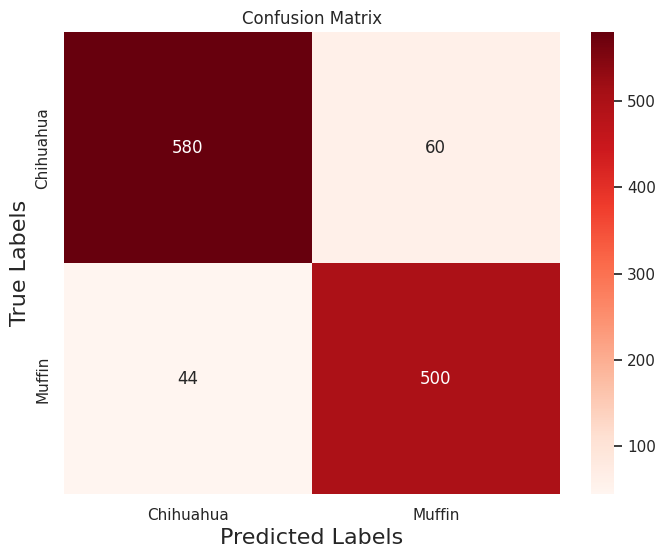

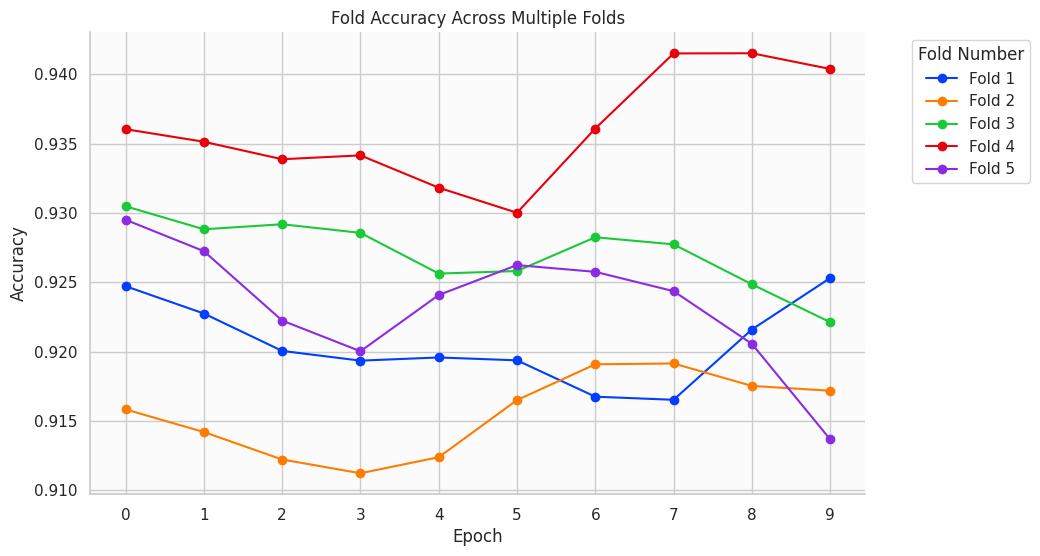

In [13]:
from tensorflow.keras.models import load_model
RS_cnn = load_model('RandomSearch_CNN.h5')
cnn2, train_data, test_data, kf_stats, report = get_model_data(RS_cnn, filename="CNN2", num_epochs=10)

In [ ]:
print("Test data")
print("*********************")
print("Accuracy: ", end="")
print(test_data[1])
print("Loss: ", end="")
print(test_data[0])

Test data
*********************
Accuracy: 0.912162184715271
Loss: 0.24026994407176971


In [ ]:
report

,precision,recall,f1-score,support
0,0.929487,0.906250,0.917722,640.000000
1,0.892857,0.919118,0.905797,544.000000
accuracy,0.912162,0.912162,0.912162,0.912162
macro avg,0.911172,0.912684,0.911759,1184.000000
weighted avg,0.912657,0.912162,0.912243,1184.000000


# EfficientNetB0 with Hyperparameter Tuning

In [ ]:
# ENB0 accepts images with a resoultion of 224 by 224
img_width = 224
img_height = 224
batch_size = 32

# Reload images without normalization for proper use of ENB0
train_images, train_labels = load_images('dataset/train', normalize=False)
test_images, test_labels = load_images('dataset/test', normalize=False)

In [ ]:
def search_en(hp):
    base_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')

    data_augmentation = Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=(-0.15, 0.15)),
            layers.RandomContrast(0.2),
            layers.RandomZoom(-.1, 0.1),
        ], "Data_Augmentation")

    model_en = Sequential(
        [data_augmentation,
         base_model,
         Flatten(),
         Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
         Dense(1, activation='sigmoid')]
    )
    opt = keras.optimizers.Adam(learning_rate=hp.Choice('l_r', [1e-2, 1e-3, 1e-4]))
    model_en.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model_en

In [ ]:
tuner = BayesianOptimization(
    search_en,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='./',
    project_name='chihuahua_muffin_ef',
    overwrite=True
)

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val,y_val), batch_size=32, callbacks=[early_stop])

In [1]:
tuner.get_best_hyperparameters()[0].values

{'dense_units': 192, 'l_r': 0.0001}


In [9]:
def en():
    base_model = EfficientNetB0(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet')
    model_en = Sequential(
        [base_model,
         Flatten(),
         Dense(192, activation='relu'),
         Dropout(0.2),
         Dense(1, activation='sigmoid')]
    )
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model_en.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model_en

Epoch 1/10
119/119 - 65s - loss: 0.1075 - accuracy: 0.9562 - val_loss: 0.0314 - val_accuracy: 0.9905 - 65s/epoch - 548ms/step
Epoch 2/10
119/119 - 22s - loss: 0.0437 - accuracy: 0.9849 - val_loss: 0.0323 - val_accuracy: 0.9894 - 22s/epoch - 183ms/step
Epoch 3/10
119/119 - 22s - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.0467 - val_accuracy: 0.9820 - 22s/epoch - 182ms/step
Epoch 4/10
119/119 - 22s - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.0400 - val_accuracy: 0.9852 - 22s/epoch - 182ms/step
Epoch 5/10
119/119 - 22s - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.0386 - val_accuracy: 0.9873 - 22s/epoch - 182ms/step
Epoch 6/10
119/119 - 22s - loss: 0.0098 - accuracy: 0.9960 - val_loss: 0.0455 - val_accuracy: 0.9852 - 22s/epoch - 182ms/step
Epoch 7/10
119/119 - 22s - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0319 - val_accuracy: 0.9894 - 22s/epoch - 182ms/step
Epoch 8/10
119/119 - 22s - loss: 0.0075 - accuracy: 0.9968 - val_loss: 0.0480 - val_accuracy: 0.9852 - 22s/epoch - 182

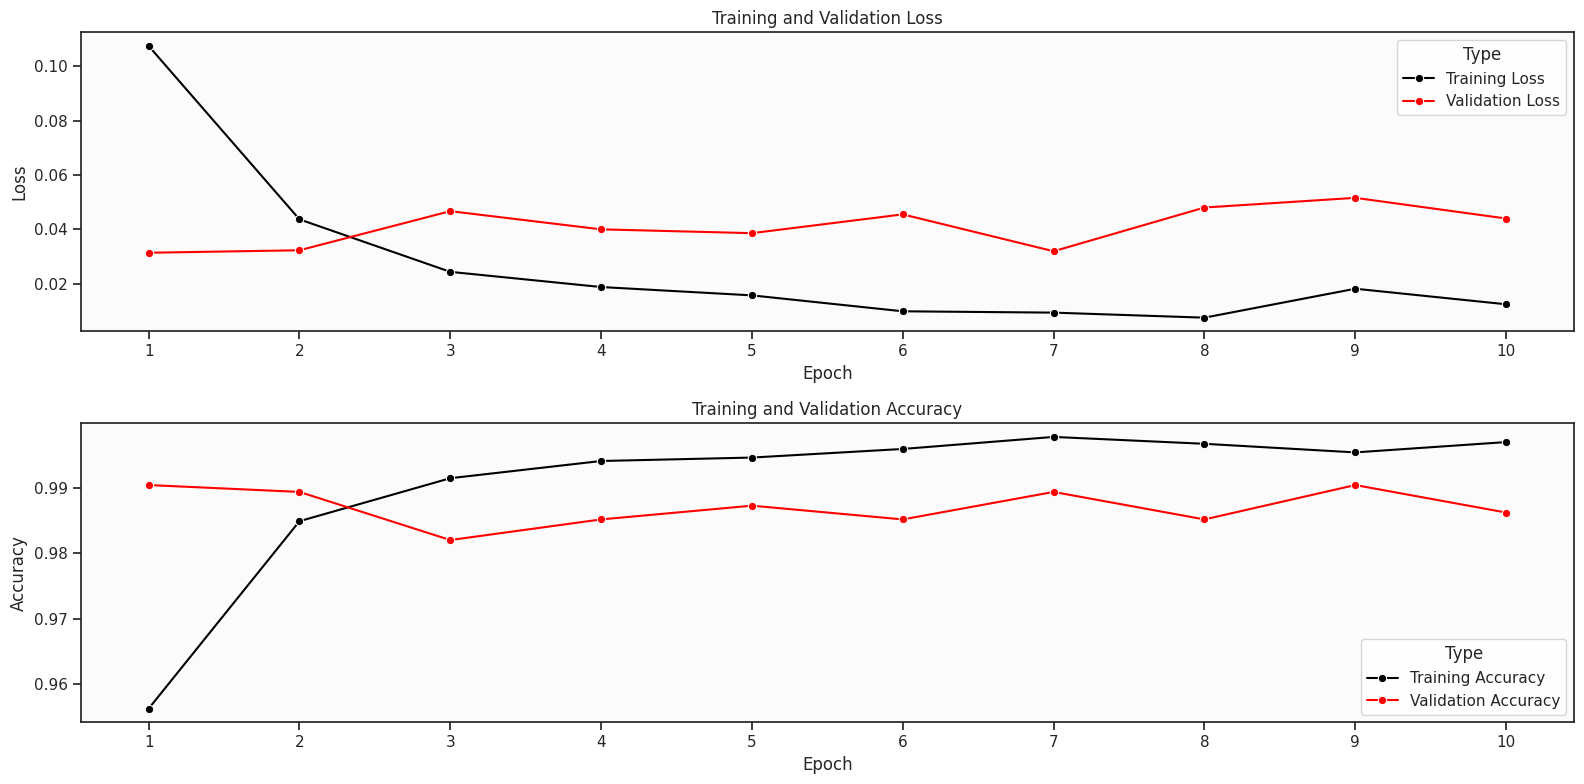

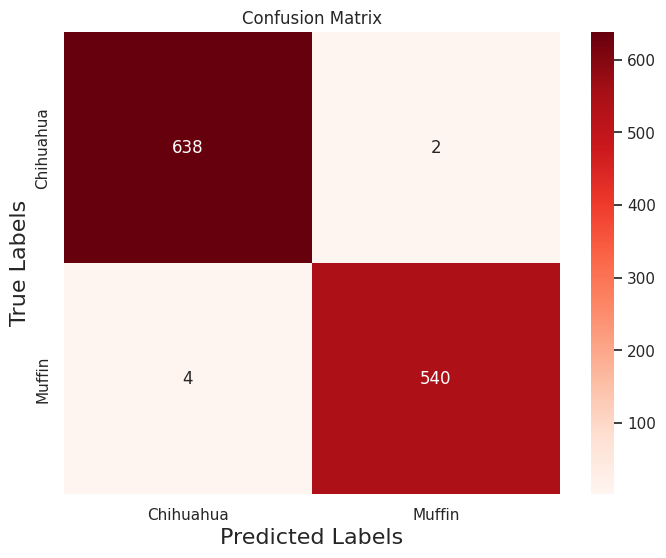

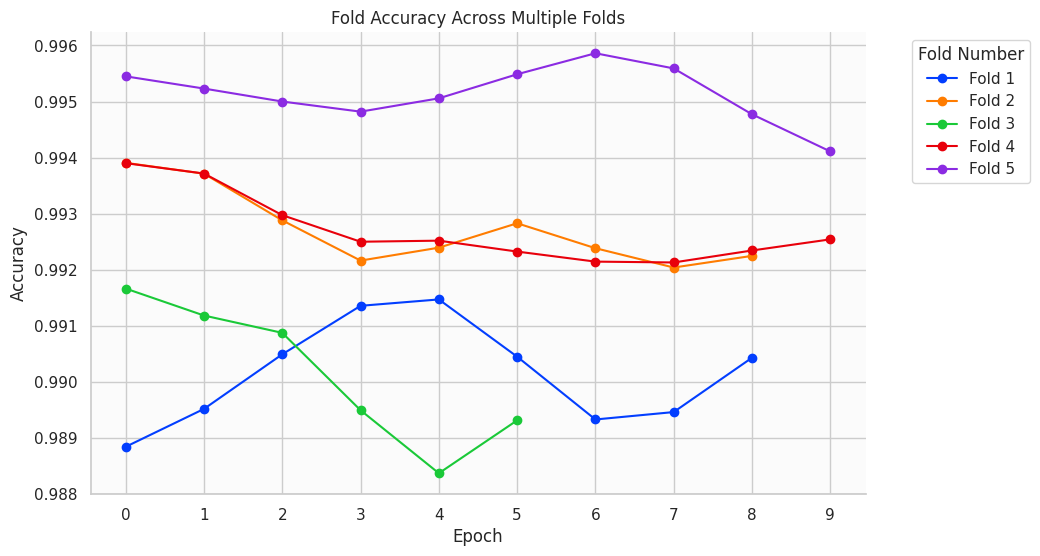

In [10]:
en, train_data, test_data, kf_stats, report = get_model_data(en(), filename="EN", num_epochs=10)

In [11]:
print("Test data")
print("*********************")
print("Accuracy: ", end="")
print(test_data[1])
print("Loss: ", end="")
print(test_data[0])

Test data
*********************
Accuracy: 0.9949324131011963
Loss: 0.013496906496584415


In [12]:
report

,precision,recall,f1-score,support
0,0.993769,0.996875,0.995320,640.000000
1,0.996310,0.992647,0.994475,544.000000
accuracy,0.994932,0.994932,0.994932,0.994932
macro avg,0.995040,0.994761,0.994897,1184.000000
weighted avg,0.994937,0.994932,0.994932,1184.000000
